In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from nltk.stem import PorterStemmer
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergeiakhmadulin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
train = pd.read_csv("/Users/sergeiakhmadulin/My Drive/Fake news/train.csv", on_bad_lines='skip',sep=';')
val = pd.read_csv("/Users/sergeiakhmadulin/My Drive/Fake news/evaluation.csv", on_bad_lines='skip',sep=';')
test = pd.read_csv("/Users/sergeiakhmadulin/My Drive/Fake news/test.csv", on_bad_lines='skip',sep=';')

In [24]:
# Function to calculate the proportion of 1's and 0's in the target column
def calculate_proportions(df):
    prop_1 = df['label'].mean()  # proportion of 1's
    prop_0 = 1 - prop_1          # proportion of 0's
    return prop_0, prop_1

In [27]:
# Calculate proportions for each dataset
prop_0_train, prop_1_train = calculate_proportions(train)
prop_0_val, prop_1_val = calculate_proportions(val)
prop_0_test, prop_1_test = calculate_proportions(test)

# Create a DataFrame for plotting
proportions = pd.DataFrame({
    'Real': [prop_0_train, prop_0_val, prop_0_test],
    'Fake': [prop_1_train, prop_1_val, prop_1_test]
}, index=['Train', 'Validation', 'Test'])


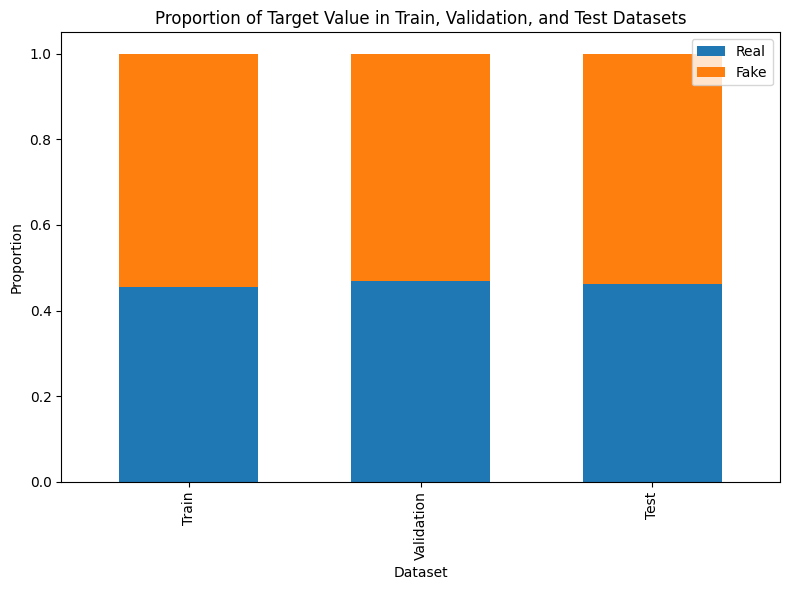

In [28]:
# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the stacked bar chart
proportions.plot(kind='bar', stacked=True, ax=ax, width=0.6)

# Add labels and title
ax.set_xlabel('Dataset')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of Target Value in Train, Validation, and Test Datasets')

# Set custom x-axis labels for each dataset
ax.set_xticklabels(['Train', 'Validation', 'Test'])

# Display the plot
plt.tight_layout()
plt.show()

In [34]:
def text_prepare(text):
    """
    Function that does a general text preparation

    Parameters:
    text: corpus of text documents

    Output:

    text without spetial characters, "stop words" and in lower case
    """
    REPLACE_BY_SPACE_RE = re.compile(r'[^a-zA-Z0-9\s]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    text = text.lower()

    text = REPLACE_BY_SPACE_RE.sub(r' ',text)
    text = BAD_SYMBOLS_RE.sub(r'',text)
    text = [w for w in text.split() if not w in STOPWORDS]
    
    return ' '.join(text)

In [35]:
X_train_cleaned = [text_prepare(x) for x in train]
X_test_cleaned = [text_prepare(x) for x in test]
X_val_cleaned = [text_prepare(x) for x in val]

In [45]:
train["all_test"] = train['title'] + " " + train["text"]
val["all_test"] = val['title'] + " " + val["text"]
test["all_test"] = test['title'] + " " + test["text"]

In [50]:
X_train_cleaned = [text_prepare(x) for x in train["all_test"]]
X_val_cleaned = [text_prepare(x) for x in val["all_test"]]
X_test_cleaned = [text_prepare(x) for x in test["all_test"]]

In [51]:
stemmer = PorterStemmer()

In [55]:
X_train_stemmed = [stemmer.stem(word) for word in X_train_cleaned]
X_val_stemmed = [stemmer.stem(word) for word in X_val_cleaned]
X_test_stemmed = [stemmer.stem(word) for word in X_test_cleaned]

In [60]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

In [61]:
X_train_matrix = tfidf.fit_transform(X_train_stemmed)
X_val_matrix = tfidf.transform(X_val_stemmed)
X_test_matrix = tfidf.transform(X_test_stemmed)

In [66]:
y_train = train["label"]
y_val = val["label"]
y_test = test["label"]

In [67]:
svm_model = SVC(kernel='linear', random_state=42)

In [79]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    # 'gamma': ['scale', 'auto'],  # For non-linear kernels (like RBF)
    # 'kernel': ['linear', 'rbf']  # Linear and RBF kernel types
}

In [80]:
from sklearn.svm import LinearSVC

# LinearSVC is optimized for large datasets with sparse matrices
svm_model = LinearSVC(random_state=42, max_iter=10000)  # You can increase max_iter if needed

In [96]:
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1, verbose = 2)
grid_search.fit(X_train_matrix, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ................................................C=1; total time=   2.7s
[CV] END ...............................................C=10; total time=   7.2s
[CV] END ..............................................C=0.1; total time=   1.6s
[CV] END ...............................................C=10; total time=  12.2s
[CV] END ..............................................C=100; total time=  34.9s
[CV] END ..............................................C=0.1; total time=   1.6s
[CV] END ...............................................C=10; total time=  12.2s


GridSearchCV(cv=5, estimator=LinearSVC(max_iter=10000, random_state=42),
             n_jobs=-1, param_grid={'C': [0.1, 1, 10, 100]},
             scoring='precision', verbose=2)

In [97]:
best_svm_model = grid_search.best_estimator_

# Step 5: Evaluate the model on the test set
y_pred = best_svm_model.predict(X_test_matrix)

# Classification report to evaluate performance
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      3753
           1       0.98      0.98      0.98      4364

    accuracy                           0.98      8117
   macro avg       0.98      0.98      0.98      8117
weighted avg       0.98      0.98      0.98      8117



In [98]:
def plot_confusion_matrix(Y_true, Y_pred):
    cm = confusion_matrix(Y_true, Y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=list(proportions.columns), yticklabels=list(proportions.columns))
    
    # Set plot labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

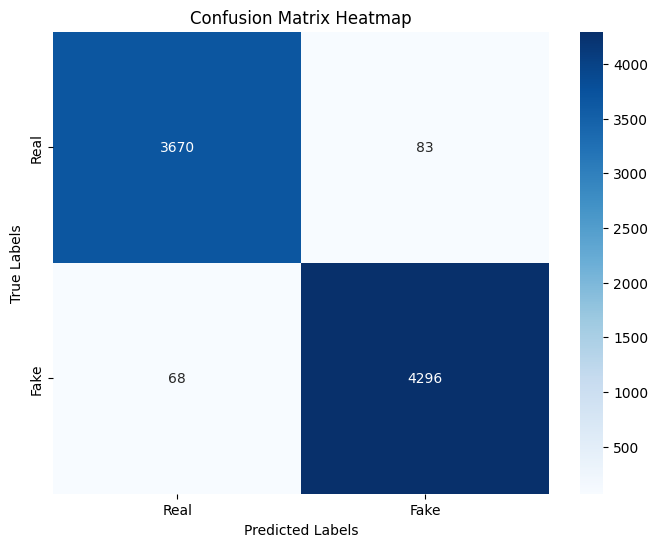

In [99]:
plot_confusion_matrix(y_test, y_pred)

In [100]:
y_pred_val = best_svm_model.predict(X_val_matrix)

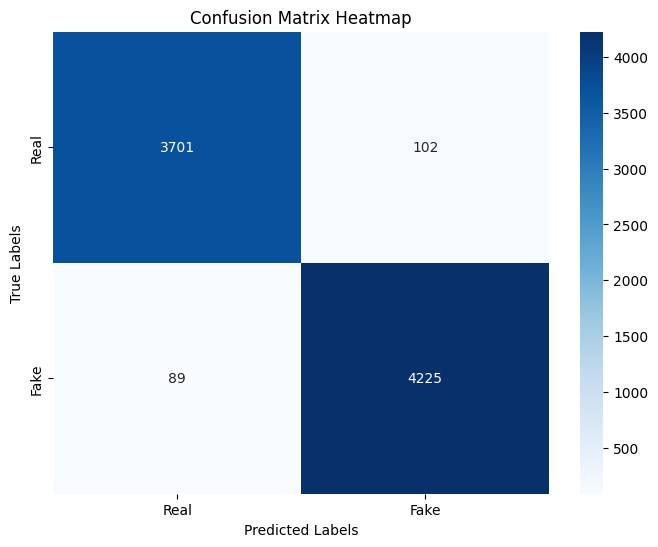

In [101]:
plot_confusion_matrix(y_val, y_pred_val)

In [ ]:
from transformers import AutoTokenizer

# Load a pre-trained tokenizer (you can choose a different model)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Example text to tokenize
text = "Hugging Face provides an awesome library for NLP."

# Tokenize the text
tokens = tokenizer.tokenize(text)

# Print the tokens
print(tokens)

In [ ]:
pip install transformers torch